This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Export a dataset in GIS-compatible format

In this notebook, we demonstrate how to export a gridded dataset in GeoTIFF and ESRI ASCII format. This will be exemplified using RADOLAN data from the German Weather Service.

You have two options for output:

- `rioxarray.to_raster` 
- builtin GDAL functionality

In [1]:
import matplotlib.pyplot as plt
import os
import wradlib as wrl
import xarray as xr
import numpy as np
import warnings
from pyproj.crs import CRS

warnings.filterwarnings("ignore")

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

### Step 1: Read the original data

In [2]:
# We will export this RADOLAN dataset to a GIS compatible format
wdir = wrl.util.get_wradlib_data_path() + "/radolan/grid/"
if not os.path.exists(wdir):
    os.makedirs(wdir)

filename = "radolan/misc/raa01-sf_10000-1408102050-dwd---bin.gz"
filename = wrl.util.get_wradlib_data_file(filename)
ds = xr.open_dataset(filename, engine="radolan")
display(ds)

<xarray.Dataset>
Dimensions:  (y: 900, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2014-08-10T20:50:00
  * y        (y) float64 -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
  * x        (x) float64 -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
Data variables:
    SF       (y, x) float32 ...
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.13.1
    radarlocations:  ['boo', 'ros', 'emd', 'hnr', 'umd', 'pro', 'ess', 'asd',...
    radardays:       ['asd 24', 'boo 24', 'emd 24', 'ess 24', 'fbg 24', 'hnr ...

In [3]:
# This is the RADOLAN projection
proj_osr = wrl.georef.create_osr("dwd-radolan")
crs = CRS.from_wkt(proj_osr.ExportToWkt(["FORMAT=WKT2_2018"]))
print(proj_osr)

PROJCS["Radolan Projection",
    GEOGCS["Radolan Coordinate System",
        DATUM["Radolan_Kugel",
            SPHEROID["Erdkugel",6370040,0]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",60],
    PARAMETER["central_meridian",10],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["kilometre",1000,
        AUTHORITY["EPSG","9036"]],
    AXIS["Easting",SOUTH],
    AXIS["Northing",SOUTH]]


### Step 2a (output with rioxarray)

drop encoding

In [4]:
ds.SF.encoding = {}

In [5]:
ds = ds.rio.write_crs(crs)
ds.SF.rio.to_raster(wdir + "geotiff_rio.tif", driver="GTiff")

In [6]:
ds.SF.rio.to_raster(
    wdir + "aaigrid_rio.asc",
    driver="AAIGrid",
    profile_kwargs=dict(options=["DECIMAL_PRECISION=2"]),
)

### Step 2b: (output with GDAL)

#### Get the projected coordinates of the RADOLAN grid

In [7]:
# Get projected RADOLAN coordinates for corner definition
xy_raw = wrl.georef.get_radolan_grid(900, 900)
xy_raw.shape

(900, 900, 2)

#### Check Origin and Row/Column Order

We know, that `wrl.read_radolan_composite` returns a 2D-array (rows, cols) with the origin in the lower left corner. Same applies to `wrl.georef.get_radolan_grid`. For the next step, we need to flip the data and the coords up-down. The coordinate corner points also need to be adjusted from lower left corner to upper right corner.

In [8]:
data, xy = wrl.georef.set_raster_origin(ds.SF.values, xy_raw, "upper")
print(data.shape)

(900, 900)


#### Export as GeoTIFF

For RADOLAN grids, this projection will probably not be recognized by
ESRI ArcGIS.

In [9]:
# create 3 bands
data = np.stack((data, data + 100, data + 1000), axis=0)
print(data.shape)
gds = wrl.georef.create_raster_dataset(data, xy, crs=proj_osr)
wrl.io.write_raster_dataset(wdir + "geotiff.tif", gds, driver="GTiff")

(3, 900, 900)


#### Export as ESRI ASCII file (aka Arc/Info ASCII Grid)

In [10]:
# Export to Arc/Info ASCII Grid format (aka ESRI grid)
#     It should be possible to import this to most conventional
# GIS software.
# only use first band
proj_esri = proj_osr.Clone()
proj_esri.MorphToESRI()
ds = wrl.georef.create_raster_dataset(data[0], xy, crs=proj_esri)
wrl.io.write_raster_dataset(
    wdir + "aaigrid.asc", ds, driver="AAIGrid", options=["DECIMAL_PRECISION=2"]
)

### Step 3a: Read with xarray/rioxarray

<xarray.Dataset>
Dimensions:      (band: 3, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 -523.5 -522.5 -521.5 -520.5 ... 373.5 374.5 375.5
  * y            (y) float64 -3.76e+03 -3.761e+03 ... -4.658e+03 -4.659e+03
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
  * y            (y) float64 -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

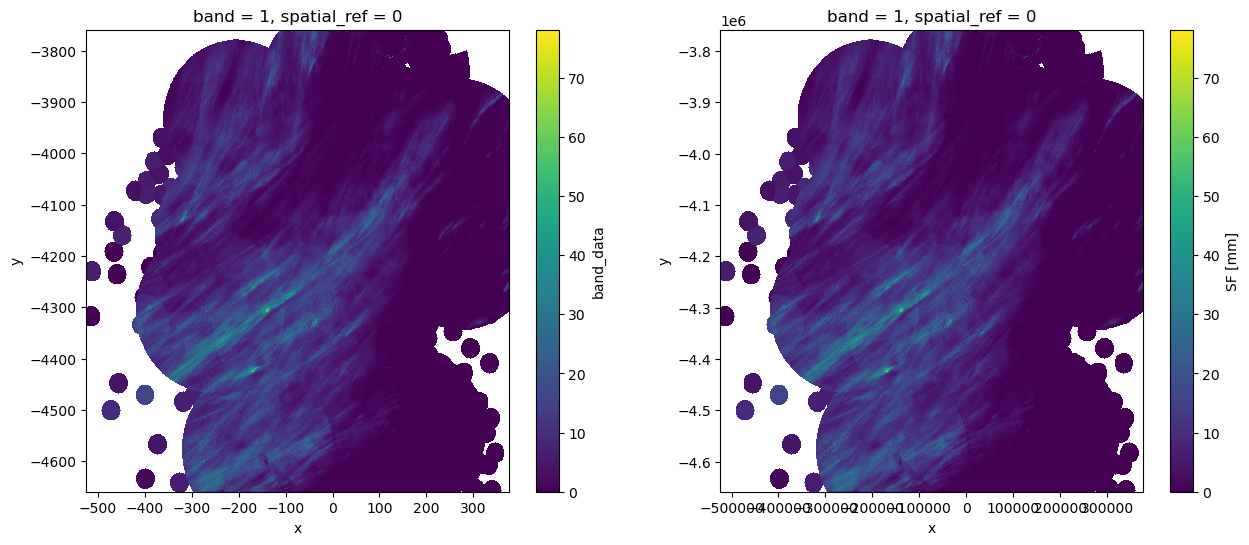

In [11]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
with xr.open_dataset(wdir + "geotiff.tif") as ds1:
    display(ds1)
    ds1.sel(band=1).band_data.plot(ax=ax1)
ax2 = fig.add_subplot(122)
with xr.open_dataset(wdir + "geotiff_rio.tif") as ds2:
    display(ds2)
    ds2.sel(band=1).band_data.plot(ax=ax2)

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -523.5 -522.5 -521.5 -520.5 ... 373.5 374.5 375.5
  * y            (y) float64 -3.76e+03 -3.761e+03 ... -4.658e+03 -4.659e+03
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
  * y            (y) float64 -3.759e+06 -3.76e+06 ... -4.657e+06 -4.658e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

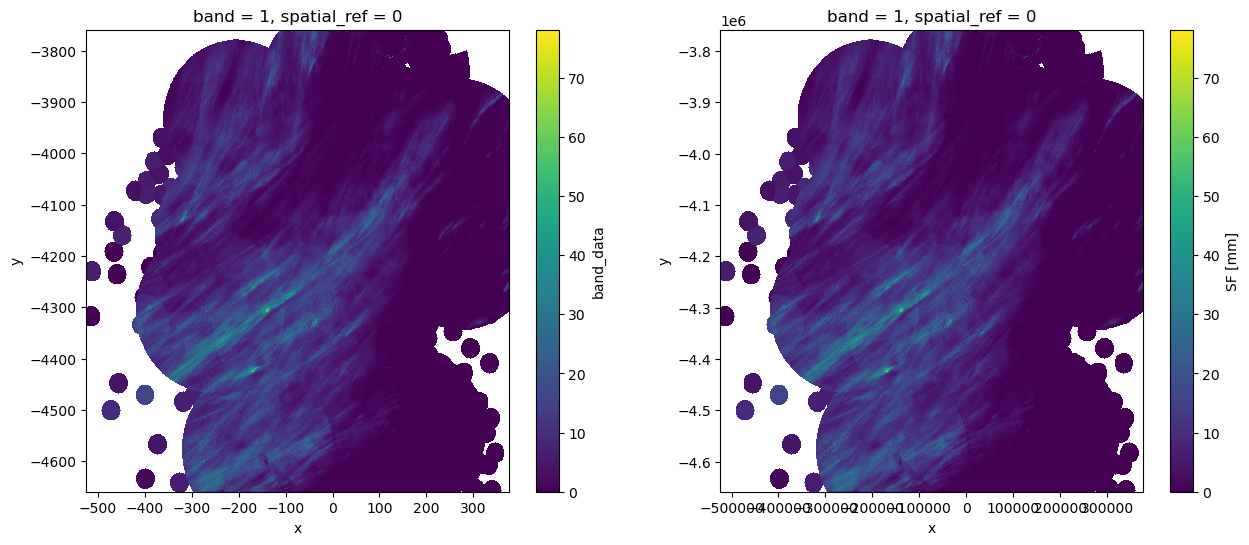

In [12]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
with xr.open_dataset(wdir + "aaigrid.asc") as ds1:
    display(ds1)
    ds1.sel(band=1).band_data.plot(ax=ax1)
ax2 = fig.add_subplot(122)
with xr.open_dataset(wdir + "aaigrid_rio.asc") as ds2:
    display(ds2)
    ds2.sel(band=1).band_data.plot(ax=ax2)

### Step 3b: Read with GDAL

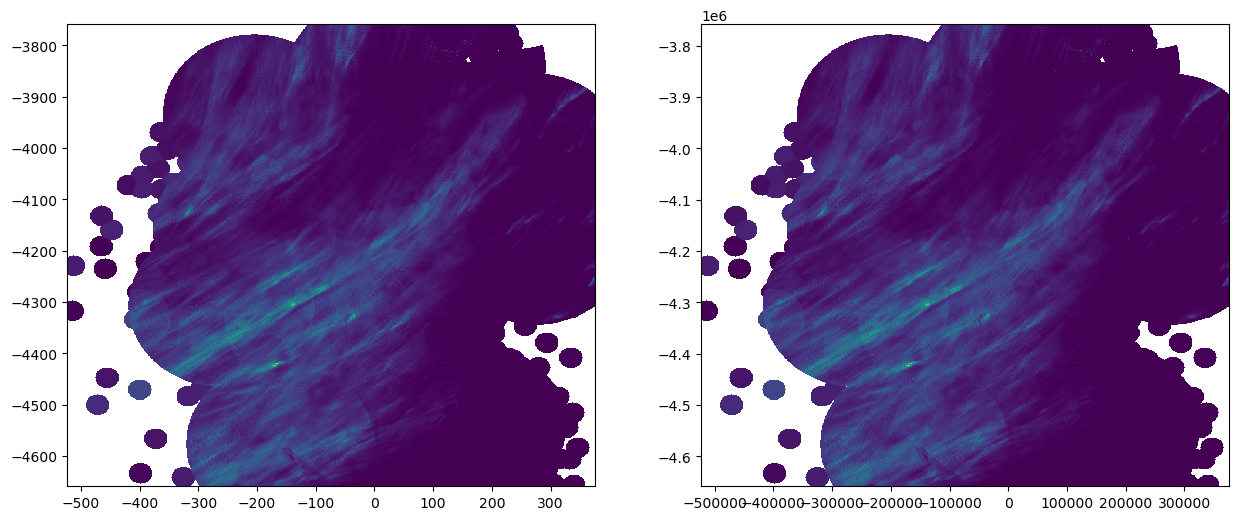

In [13]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ds1 = wrl.io.open_raster(wdir + "geotiff.tif")
data1, xy1, proj1 = wrl.georef.extract_raster_dataset(ds1, nodata=-9999.0)
ax1.pcolormesh(xy1[..., 0], xy1[..., 1], data1[0])

ax2 = fig.add_subplot(122)
ds2 = wrl.io.open_raster(wdir + "geotiff_rio.tif")
data2, xy2, proj2 = wrl.georef.extract_raster_dataset(ds2, nodata=-9999.0)
ax2.pcolormesh(xy2[..., 0], xy2[..., 1], data2)

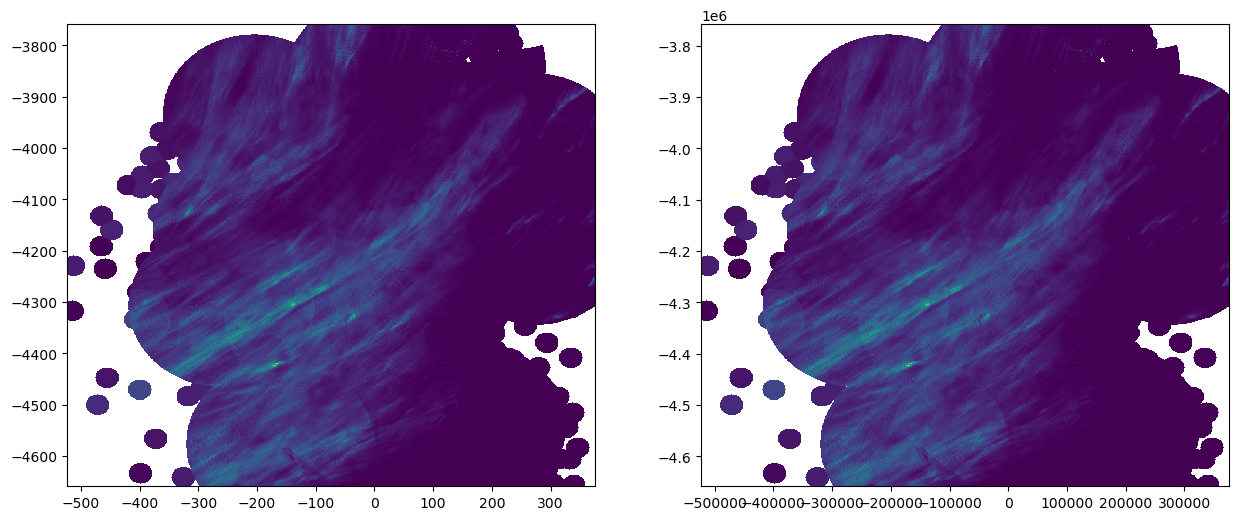

In [14]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ds1 = wrl.io.open_raster(wdir + "aaigrid.asc")
data1, xy1, proj1 = wrl.georef.extract_raster_dataset(ds1, nodata=-9999.0)
ax1.pcolormesh(xy1[..., 0], xy1[..., 1], data1)

ax2 = fig.add_subplot(122)
ds2 = wrl.io.open_raster(wdir + "aaigrid_rio.asc")
data2, xy2, proj2 = wrl.georef.extract_raster_dataset(ds2, nodata=-9999.0)
ax2.pcolormesh(xy2[..., 0], xy2[..., 1], data2)